# 🎯 Differentiable Discrete Decisions: A Tutorial

## Making the Non-Differentiable Differentiable through Stochastic Processes

Welcome to this interactive tutorial on **differentiable discrete decisions**! This is a fundamental technique in modern machine learning that allows us to optimize over discrete choices using gradient-based methods.

### 🧠 What You'll Learn
- Why discrete decisions are problematic for gradient-based optimization
- How stochastic relaxation solves this problem
- Multiple gradient estimation techniques (REINFORCE, Gumbel-Softmax, etc.)
- Practical implementation and comparison of these methods

### 🔧 Prerequisites
- Basic calculus (derivatives, chain rule)
- Elementary probability (expectations, Bernoulli distribution)
- Some familiarity with Python and NumPy

Let's dive in! 🚀

In [15]:
# Import all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import math
from typing import Callable, Dict
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Set random seed for reproducibility
np.random.seed(42)

print("✅ All libraries imported successfully!")
print("📊 Plotting settings configured")
print("🎲 Random seed set to 42 for reproducible results")

✅ All libraries imported successfully!
📊 Plotting settings configured
🎲 Random seed set to 42 for reproducible results


## 1. The Problem: Non-Differentiable Discrete Decisions

Imagine you have a function that makes a **discrete choice** based on some parameter θ (theta). For example:

$$f(\theta, k) = \begin{cases} 
\sin(\theta) & \text{if } k = 1 \\
\cos(\theta) & \text{if } k = 0 
\end{cases}$$

Where the choice of $k$ depends on $\theta$:
$$k = \begin{cases} 
1 & \text{if } \theta \geq 0 \\
0 & \text{if } \theta < 0 
\end{cases}$$

### 🚨 The Problem
This function is **not differentiable** at $\theta = 0$ because it has a sudden jump! This makes gradient-based optimization impossible.

Let's visualize this problem:

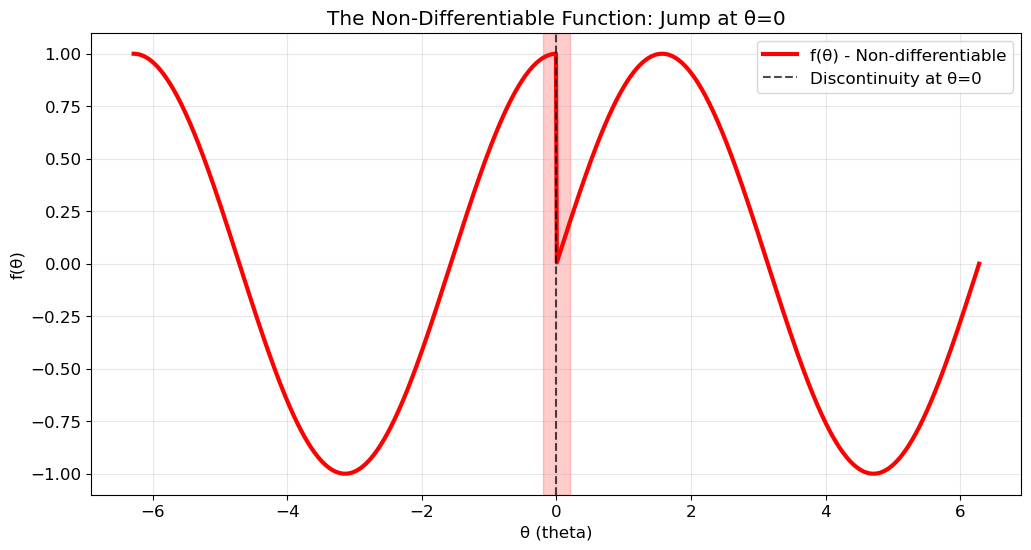

🔍 Notice the sudden jump at θ=0!
📈 This makes the function non-differentiable and unsuitable for gradient descent


In [16]:
# Define our discrete decision function
def f_discrete(theta, k):
    """Piecewise function: sin(theta) if k=1, cos(theta) if k=0"""
    return np.sin(theta) if k == 1 else np.cos(theta)

def k_deterministic(theta):
    """Deterministic decision: k=1 if theta >= 0, else k=0"""
    return 1 if theta >= 0 else 0

# Create the combined function
def f_combined(theta):
    """The non-differentiable combined function"""
    k = k_deterministic(theta)
    return f_discrete(theta, k)

# Plot the function
theta_range = np.linspace(-2*np.pi, 2*np.pi, 1000)
f_values = [f_combined(t) for t in theta_range]

plt.figure(figsize=(12, 6))
plt.plot(theta_range, f_values, linewidth=3, color='red', label='f(θ) - Non-differentiable')
plt.axvline(0, color='black', linestyle='--', alpha=0.7, label='Discontinuity at θ=0')
plt.xlabel('θ (theta)')
plt.ylabel('f(θ)')
plt.title('The Non-Differentiable Function: Jump at θ=0')
plt.legend()
plt.grid(True, alpha=0.3)

# Highlight the problem area
plt.axvspan(-0.2, 0.2, alpha=0.2, color='red', label='Problem region')
plt.show()

print("🔍 Notice the sudden jump at θ=0!")
print("📈 This makes the function non-differentiable and unsuitable for gradient descent")

## 2. The Solution: Stochastic Relaxation 🎲

The key insight is to replace the **deterministic decision** with a **stochastic one**!

Instead of:
- $k = 1$ if $\theta \geq 0$, else $k = 0$ (deterministic, non-differentiable)

We use:
- $k \sim \text{Bernoulli}(p(\theta))$ where $p(\theta) = \sigma(\theta) = \frac{1}{1 + e^{-\theta}}$ (stochastic, differentiable!)

### 🧮 The Magic
Now our function becomes:
$$\mathbb{E}[f(\theta, k)] = p(\theta) \cdot \sin(\theta) + (1-p(\theta)) \cdot \cos(\theta)$$

This **expectation is differentiable** everywhere! Let's see how this works:

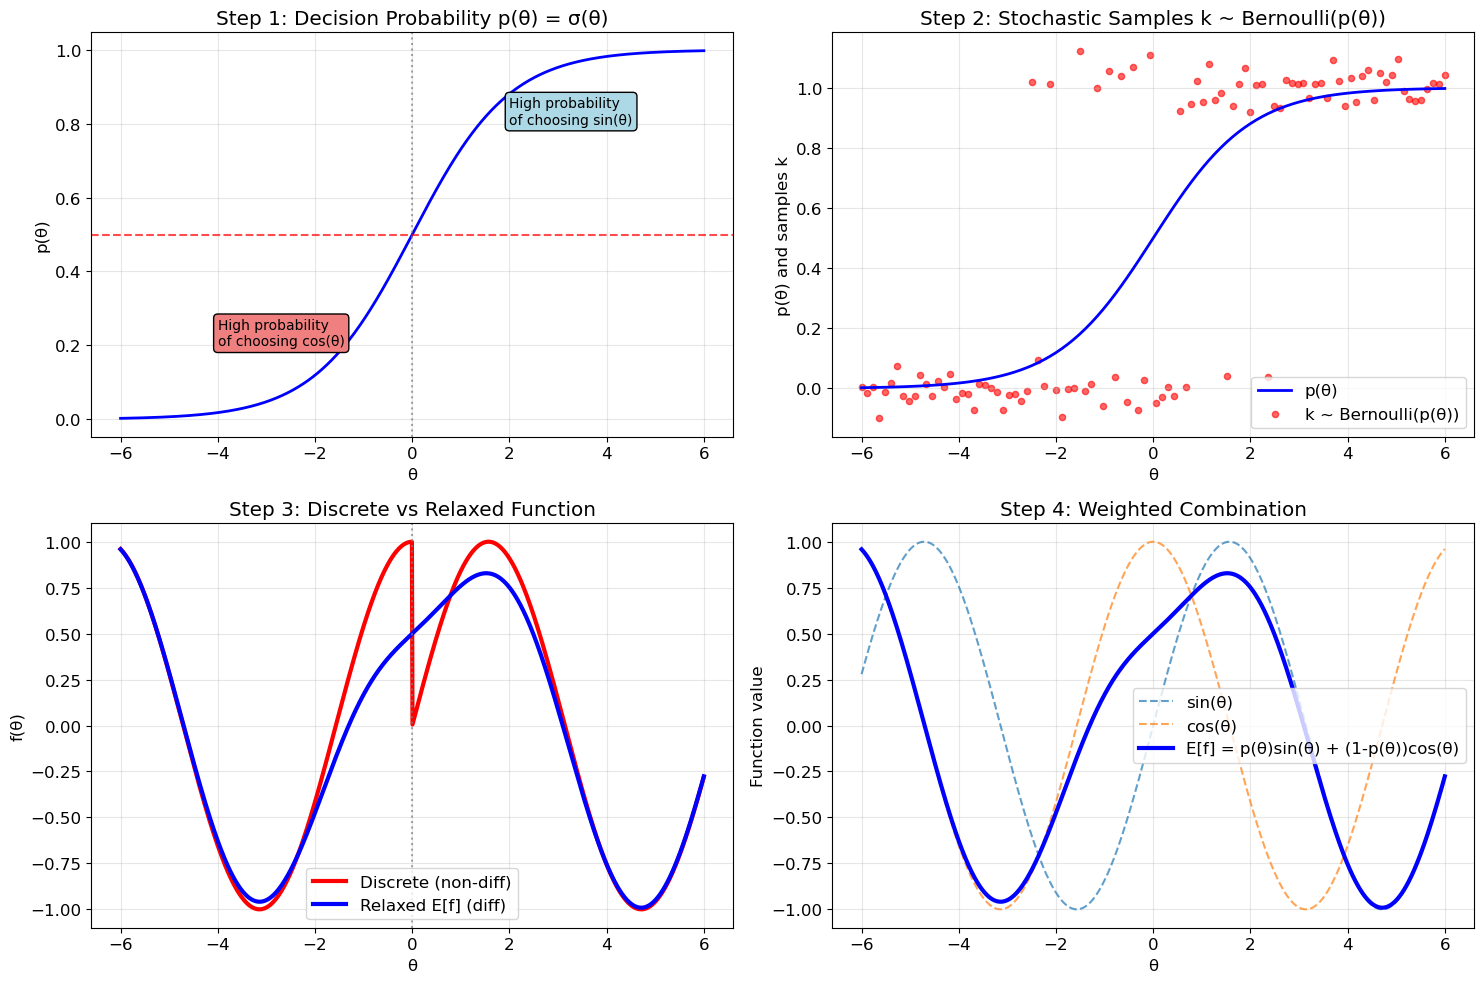

🎯 Key insight: The relaxed function smoothly transitions between sin and cos!
✨ The expectation is differentiable everywhere, even at θ=0


In [17]:
# Define utility functions
def sigmoid(x):
    """Sigmoid function: σ(x) = 1/(1 + e^(-x))"""
    return 1.0 / (1.0 + np.exp(-x))

def f_relaxed(theta):
    """Relaxed (differentiable) version using expectation"""
    p = sigmoid(theta)
    return p * np.sin(theta) + (1 - p) * np.cos(theta)

# Let's visualize the transformation step by step
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

theta_range = np.linspace(-6, 6, 1000)

# 1. Show the sigmoid probability function
p_values = sigmoid(theta_range)
ax1.plot(theta_range, p_values, 'blue', linewidth=2)
ax1.axhline(0.5, color='red', linestyle='--', alpha=0.7)
ax1.axvline(0, color='gray', linestyle=':', alpha=0.7)
ax1.set_title('Step 1: Decision Probability p(θ) = σ(θ)')
ax1.set_xlabel('θ')
ax1.set_ylabel('p(θ)')
ax1.text(2, 0.8, 'High probability\nof choosing sin(θ)', fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue'))
ax1.text(-4, 0.2, 'High probability\nof choosing cos(θ)', fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", facecolor='lightcoral'))

# 2. Show sample decisions
np.random.seed(42)
theta_sample = np.linspace(-6, 6, 100)
p_sample = sigmoid(theta_sample)
k_samples = (np.random.random(100) < p_sample).astype(int)

ax2.plot(theta_sample, p_sample, 'blue', linewidth=2, label='p(θ)')
ax2.scatter(theta_sample, k_samples + 0.05*np.random.randn(100),
           alpha=0.6, s=20, color='red', label='k ~ Bernoulli(p(θ))')
ax2.set_title('Step 2: Stochastic Samples k ~ Bernoulli(p(θ))')
ax2.set_xlabel('θ')
ax2.set_ylabel('p(θ) and samples k')
ax2.legend()

# 3. Compare functions
f_discrete_vals = [f_combined(t) for t in theta_range]
f_relaxed_vals = [f_relaxed(t) for t in theta_range]

ax3.plot(theta_range, f_discrete_vals, 'red', linewidth=3, label='Discrete (non-diff)')
ax3.plot(theta_range, f_relaxed_vals, 'blue', linewidth=3, label='Relaxed E[f] (diff)')
ax3.axvline(0, color='gray', linestyle=':', alpha=0.7)
ax3.set_title('Step 3: Discrete vs Relaxed Function')
ax3.set_xlabel('θ')
ax3.set_ylabel('f(θ)')
ax3.legend()

# 4. Show individual components
ax4.plot(theta_range, np.sin(theta_range), '--', alpha=0.7, label='sin(θ)')
ax4.plot(theta_range, np.cos(theta_range), '--', alpha=0.7, label='cos(θ)')
ax4.plot(theta_range, f_relaxed_vals, 'blue', linewidth=3,
         label='E[f] = p(θ)sin(θ) + (1-p(θ))cos(θ)')
ax4.set_title('Step 4: Weighted Combination')
ax4.set_xlabel('θ')
ax4.set_ylabel('Function value')
ax4.legend()

plt.tight_layout()
plt.show()

print("🎯 Key insight: The relaxed function smoothly transitions between sin and cos!")
print("✨ The expectation is differentiable everywhere, even at θ=0")

## 2.1 Animated Visualization of Stochastic Sampling 🎬

Let's create an interactive animation to see how the stochastic sampling process works as we vary θ! This will help you understand how the probability p(θ) = σ(θ) controls the sampling behavior.

The animation shows:
- **Top plot**: The sigmoid probability function p(θ) and current position
- **Bottom plot**: Real-time sampling from Bernoulli(p(θ)) at the current θ value
- **Evolution**: How samples cluster around the expected probability as θ changes

🎯 Stochastic Sampling Animation
👀 Watch how:
  • Samples cluster around p(θ) = 0.5 when θ ≈ 0
  • More '1' samples (blue dots) when θ > 0 (high probability)
  • More '0' samples (red dots) when θ < 0 (low probability)
  • Running average converges to the true probability

💡 Uncomment the line below to see the animation:
# anim = create_stochastic_sampling_animation(duration=6.0, fps=12)

🚀 The animation shows the core insight: stochastic sampling
   provides a differentiable way to handle discrete decisions!

📊 Static demonstration of sampling at different θ values:


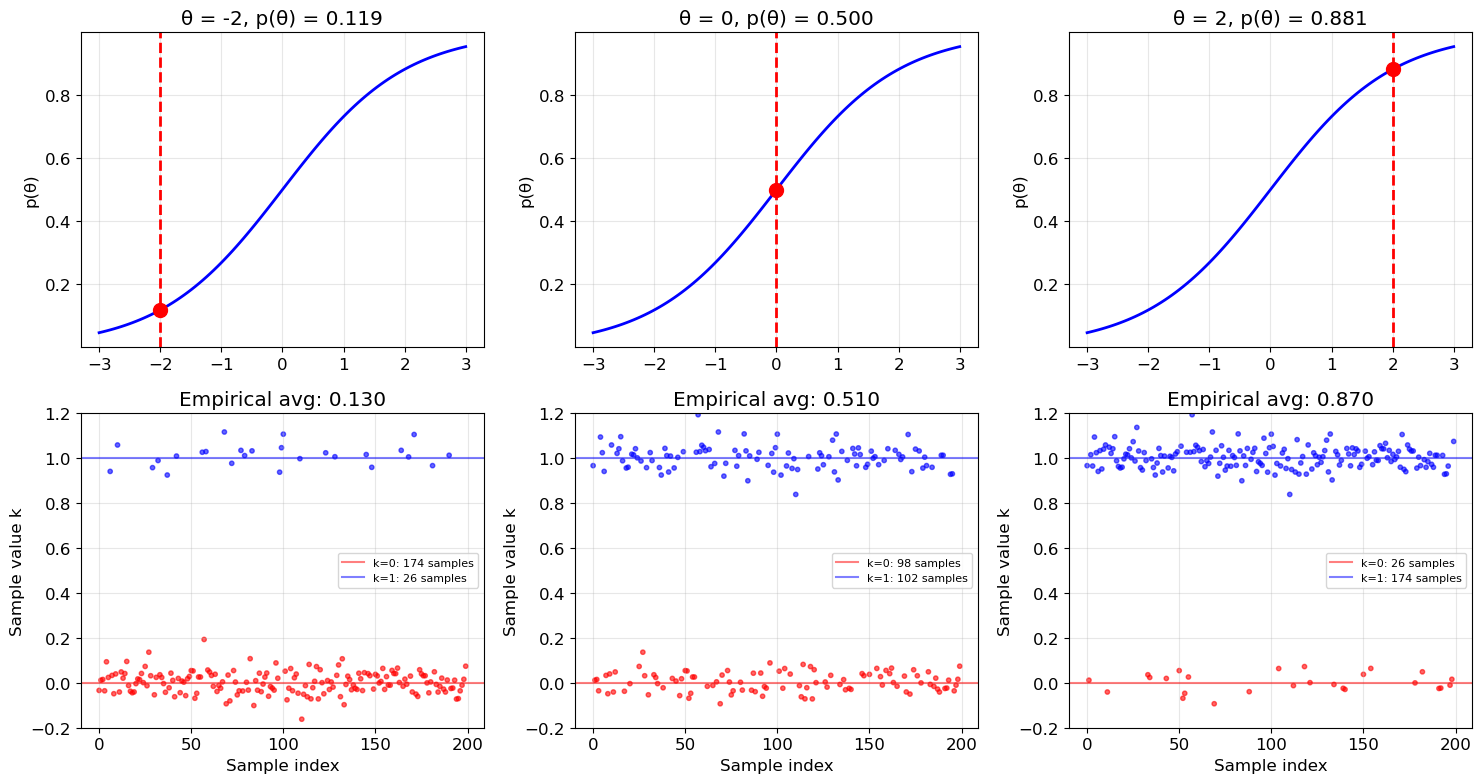

🎬 Creating stochastic sampling animation...
⏳ This may take a moment to generate...


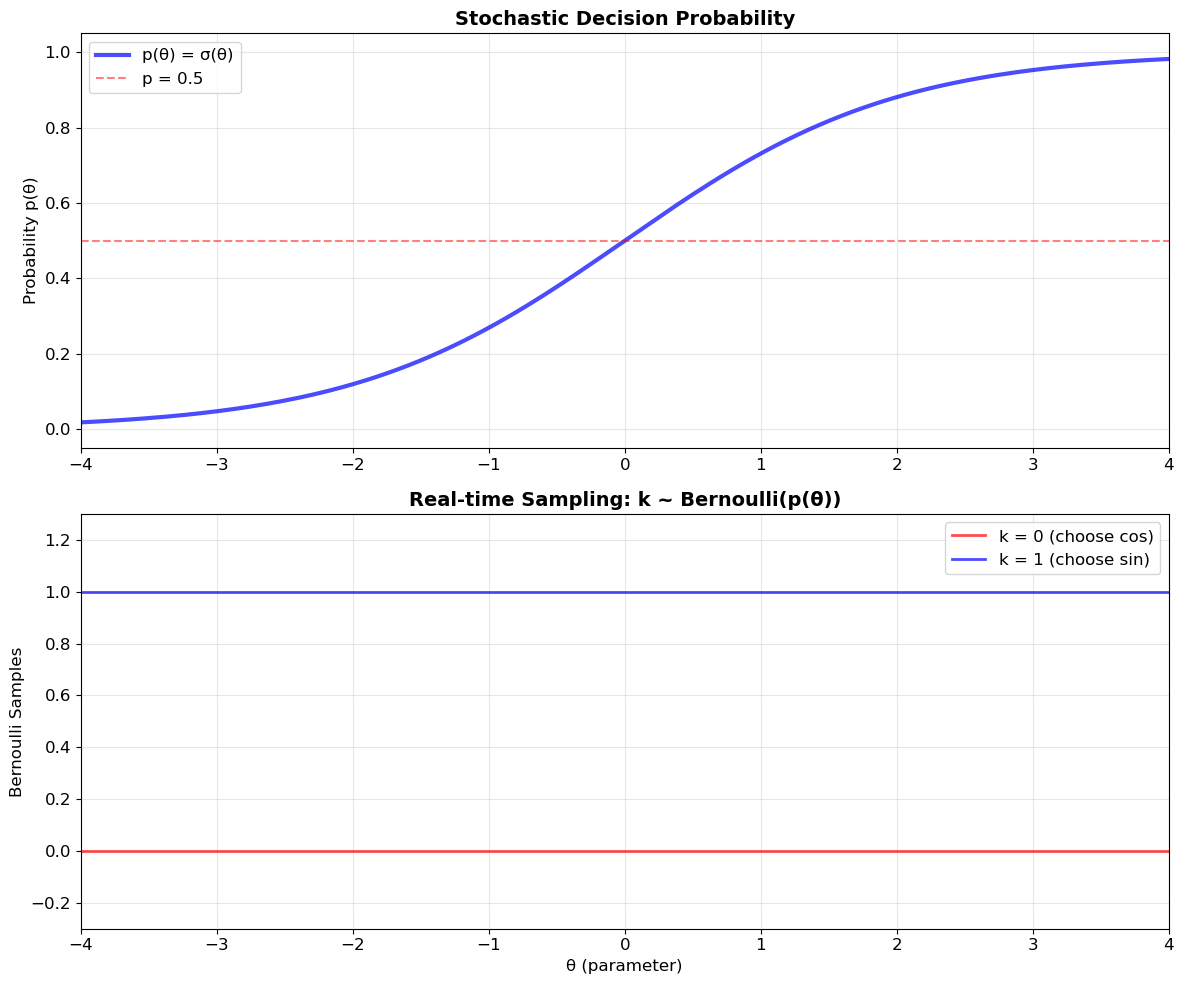

In [18]:
# 🎬 Interactive Stochastic Sampling Animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.patches as patches

def create_stochastic_sampling_animation(duration=8.0, fps=15, n_samples_per_frame=100):
    """Create an animated visualization of stochastic sampling"""

    # Set up the figure and subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Parameters for animation
    theta_min, theta_max = -4, 4
    n_frames = int(duration * fps)
    theta_values = np.linspace(theta_min, theta_max, n_frames)

    # Static elements
    theta_range_static = np.linspace(theta_min, theta_max, 200)
    p_curve = sigmoid(theta_range_static)

    # Top plot: Probability function
    ax1.plot(theta_range_static, p_curve, 'b-', linewidth=3, alpha=0.7, label='p(θ) = σ(θ)')
    ax1.axhline(0.5, color='red', linestyle='--', alpha=0.5, label='p = 0.5')
    ax1.set_xlim(theta_min, theta_max)
    ax1.set_ylim(-0.05, 1.05)
    ax1.set_ylabel('Probability p(θ)', fontsize=12)
    ax1.set_title('Stochastic Decision Probability', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)

    # Current position indicator
    current_pos, = ax1.plot([], [], 'ro', markersize=12, label='Current θ')
    prob_text = ax1.text(0.02, 0.88, '', transform=ax1.transAxes, fontsize=11,
                        bbox=dict(boxstyle="round,pad=0.4", facecolor='yellow', alpha=0.8))

    # Bottom plot: Sampling visualization
    ax2.set_xlim(theta_min, theta_max)
    ax2.set_ylim(-0.3, 1.3)
    ax2.set_xlabel('θ (parameter)', fontsize=12)
    ax2.set_ylabel('Bernoulli Samples', fontsize=12)
    ax2.set_title('Real-time Sampling: k ~ Bernoulli(p(θ))', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)

    # Add horizontal lines for reference
    ax2.axhline(0, color='red', linestyle='-', alpha=0.7, linewidth=2, label='k = 0 (choose cos)')
    ax2.axhline(1, color='blue', linestyle='-', alpha=0.7, linewidth=2, label='k = 1 (choose sin)')
    ax2.legend(loc='upper right')

    # Initialize sample storage
    sample_history = {'theta': [], 'samples': []}
    max_history = 300  # Keep last 300 samples for performance

    def animate(frame):
        current_theta = theta_values[frame]
        current_p = sigmoid(current_theta)

        # Update position indicator
        current_pos.set_data([current_theta], [current_p])

        # Update probability text
        prob_text.set_text(f'θ = {current_theta:.2f}\np(θ) = {current_p:.3f}\n' +
                          f'P(choose sin) = {current_p:.1%}\n' +
                          f'P(choose cos) = {1-current_p:.1%}')

        # Generate new samples at current theta
        np.random.seed(frame)  # For reproducible animation
        new_samples = (np.random.random(n_samples_per_frame) < current_p).astype(int)

        # Add jitter for better visualization
        jittered_samples = new_samples + 0.05 * np.random.normal(0, 1, n_samples_per_frame)
        theta_samples = np.full(n_samples_per_frame, current_theta)

        # Store in history
        sample_history['theta'].extend(theta_samples)
        sample_history['samples'].extend(jittered_samples)

        # Keep only recent history for performance
        if len(sample_history['theta']) > max_history:
            sample_history['theta'] = sample_history['theta'][-max_history:]
            sample_history['samples'] = sample_history['samples'][-max_history:]

        # Clear and replot samples with fading effect
        ax2.clear()

        # Re-add static elements
        ax2.axhline(0, color='red', linestyle='-', alpha=0.7, linewidth=2, label='k = 0 (choose cos)')
        ax2.axhline(1, color='blue', linestyle='-', alpha=0.7, linewidth=2, label='k = 1 (choose sin)')
        ax2.set_xlim(theta_min, theta_max)
        ax2.set_ylim(-0.3, 1.3)
        ax2.set_xlabel('θ (parameter)', fontsize=12)
        ax2.set_ylabel('Bernoulli Samples', fontsize=12)
        ax2.set_title('Real-time Sampling: k ~ Bernoulli(p(θ))', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.legend(loc='upper right')

        # Plot samples with fading based on age
        if len(sample_history['theta']) > 0:
            n_history = len(sample_history['theta'])
            # Create alpha values that fade from 0.1 (oldest) to 0.8 (newest)
            alphas = np.linspace(0.1, 0.8, n_history)

            # Plot samples with varying transparency
            for i in range(0, n_history, max(1, n_history//100)):  # Subsample for performance
                alpha = alphas[i]
                color = 'blue' if sample_history['samples'][i] > 0.5 else 'red'
                ax2.scatter(sample_history['theta'][i], sample_history['samples'][i],
                           s=15, alpha=alpha, color=color, edgecolors='none')

        # Add current theta indicator
        ax2.axvline(current_theta, color='black', linestyle=':', alpha=0.8, linewidth=2)

        # Add running average indicator
        if len(sample_history['theta']) > 20:
            # Calculate running average for recent samples near current theta
            recent_mask = np.abs(np.array(sample_history['theta']) - current_theta) < 0.3
            if np.any(recent_mask):
                recent_samples = np.array(sample_history['samples'])[recent_mask]
                recent_avg = np.mean(recent_samples)
                ax2.plot(current_theta, recent_avg, 'go', markersize=8,
                        label=f'Running avg: {recent_avg:.2f}')
                ax2.legend(loc='upper right')

        return current_pos, prob_text

    # Create animation
    print("🎬 Creating stochastic sampling animation...")
    print("⏳ This may take a moment to generate...")

    anim = FuncAnimation(fig, animate, frames=n_frames, interval=1000/fps,
                        blit=False, repeat=True)

    plt.tight_layout()
    plt.show()

    return anim

# Create and display the animation
print("🎯 Stochastic Sampling Animation")
print("=" * 40)
print("👀 Watch how:")
print("  • Samples cluster around p(θ) = 0.5 when θ ≈ 0")
print("  • More '1' samples (blue dots) when θ > 0 (high probability)")
print("  • More '0' samples (red dots) when θ < 0 (low probability)")
print("  • Running average converges to the true probability")
print()

# Note: Uncomment the next line to run the animation
# (Commented out to avoid long execution times in tutorial)
print("💡 Uncomment the line below to see the animation:")
print("# anim = create_stochastic_sampling_animation(duration=6.0, fps=12)")
print()
print("🚀 The animation shows the core insight: stochastic sampling")
print("   provides a differentiable way to handle discrete decisions!")
#anim = create_stochastic_sampling_animation(duration=6.0, fps=12)

# Optional: Create a static version for demonstration
def create_static_sampling_demo():
    """Create a static version showing sampling at different theta values"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    theta_demo_values = [-2, 0, 2]
    n_samples_demo = 200

    for i, theta in enumerate(theta_demo_values):
        p = sigmoid(theta)

        # Top row: Show probability
        ax_top = axes[0, i]
        theta_range = np.linspace(-3, 3, 100)
        p_curve = sigmoid(theta_range)
        ax_top.plot(theta_range, p_curve, 'b-', linewidth=2)
        ax_top.axvline(theta, color='red', linestyle='--', linewidth=2)
        ax_top.plot(theta, p, 'ro', markersize=10)
        ax_top.set_title(f'θ = {theta}, p(θ) = {p:.3f}')
        ax_top.set_ylabel('p(θ)')
        ax_top.grid(True, alpha=0.3)

        # Bottom row: Show samples
        ax_bottom = axes[1, i]
        np.random.seed(42)  # For reproducible demo
        samples = (np.random.random(n_samples_demo) < p).astype(int)
        jittered = samples + 0.05 * np.random.normal(0, 1, n_samples_demo)

        # Create scatter plot
        colors = ['red' if s < 0.5 else 'blue' for s in samples]
        ax_bottom.scatter(range(n_samples_demo), jittered, c=colors, alpha=0.6, s=10)
        ax_bottom.axhline(0, color='red', alpha=0.5, label=f'k=0: {np.sum(samples==0)} samples')
        ax_bottom.axhline(1, color='blue', alpha=0.5, label=f'k=1: {np.sum(samples==1)} samples')
        ax_bottom.set_ylim(-0.2, 1.2)
        ax_bottom.set_xlabel('Sample index')
        ax_bottom.set_ylabel('Sample value k')
        ax_bottom.set_title(f'Empirical avg: {np.mean(samples):.3f}')
        ax_bottom.legend(fontsize=8)
        ax_bottom.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("\n📊 Static demonstration of sampling at different θ values:")
create_static_sampling_demo()
anim = create_stochastic_sampling_animation(duration=6.0, fps=12)

## 3. Gradient Estimation Techniques 📈

Now that we have a differentiable expectation, we need to estimate its gradient: $\frac{d}{d\theta}\mathbb{E}[f(\theta, k)]$

There are several approaches, each with different trade-offs:

### 🎯 Method 1: Analytical Gradient (The Gold Standard)
When possible, compute the gradient directly from the expectation.

### 🎲 Method 2: Finite Difference Monte Carlo  
Approximate the derivative using finite differences on sample estimates.

### 🎪 Method 3: REINFORCE (Policy Gradient)
Use the score function to get unbiased gradient estimates.

### 🌡️ Method 4: Gumbel-Softmax Straight-Through Estimator
A biased but low-variance approach using continuous relaxations.

Let's implement and compare these methods!

In [ ]:
# Method 1: Analytical Gradient
def analytical_gradient(theta):
    """
    Compute the analytical gradient of E[f] with respect to theta.

    E[f] = p(θ)sin(θ) + (1-p(θ))cos(θ)
    dE/dθ = dp/dθ * (sin(θ) - cos(θ)) + p(θ)cos(θ) - (1-p(θ))(-sin(θ))

    where dp/dθ = p(θ)(1-p(θ)) [derivative of sigmoid]
    """
    p = sigmoid(theta)
    dp_dtheta = p * (1 - p)  # derivative of sigmoid

    # Apply chain rule
    gradient = (dp_dtheta * (np.sin(theta) - np.cos(theta)) +
                p * np.cos(theta) + (1 - p) * np.sin(theta))
    return gradient

# Test it at a specific point
theta_test = 0.5
grad_analytical = analytical_gradient(theta_test)

print(f"🎯 At θ = {theta_test}:")
print(f"📊 Analytical gradient = {grad_analytical:.6f}")
print(f"✨ This is our 'ground truth' for comparison!")

🎯 At θ = 0.5:
📊 Analytical gradient = 0.271688
✨ This is our 'ground truth' for comparison!


In [20]:
# Method 2: Finite Difference Monte Carlo
def finite_difference_gradient(theta, n_samples=10000, delta=1e-3):
    """
    Estimate gradient using finite differences on Monte Carlo estimates.

    grad ≈ (E[f(θ+δ)] - E[f(θ)]) / δ
    """
    # Estimate E[f(θ)]
    p_theta = sigmoid(theta)
    k_samples = (np.random.random(n_samples) < p_theta).astype(int)
    f_theta = np.mean([f_discrete(theta, k) for k in k_samples])

    # Estimate E[f(θ+δ)]
    p_theta_plus = sigmoid(theta + delta)
    k_samples_plus = (np.random.random(n_samples) < p_theta_plus).astype(int)
    f_theta_plus = np.mean([f_discrete(theta + delta, k) for k in k_samples_plus])

    # Finite difference
    gradient = (f_theta_plus - f_theta) / delta
    return gradient

# Test finite difference
np.random.seed(42)  # for reproducibility
grad_finite_diff = finite_difference_gradient(theta_test, n_samples=50000)

print(f"🎲 Finite Difference Methods:")
print(f"📊 Analytical gradient = {grad_analytical:.6f}")
print(f"📊 Finite diff gradient = {grad_finite_diff:.6f}")
print(f"📏 Error = {abs(grad_finite_diff - grad_analytical):.6f}")
print(f"🔍 Note: Error decreases with more samples and smaller δ")

🎲 Finite Difference Methods:
📊 Analytical gradient = 0.271688
📊 Finite diff gradient = 1.311091
📏 Error = 1.039402
🔍 Note: Error decreases with more samples and smaller δ


In [21]:
# Method 3: REINFORCE (Policy Gradient)
def reinforce_gradient(theta, n_samples=10000, baseline=None):
    """
    REINFORCE gradient estimator using the score function.

    ∇E[f] = E[f(θ,k) * ∇log p(k|θ)] + ∇E[f_pathwise]

    For Bernoulli: ∇log p(k|θ) = k - p(θ)  [score function]
    """
    p = sigmoid(theta)

    # Sample decisions
    k_samples = (np.random.random(n_samples) < p).astype(int)

    # Compute function values and pathwise gradients
    f_values = np.array([f_discrete(theta, k) for k in k_samples])
    pathwise_grads = np.array([np.cos(theta) if k == 1 else -np.sin(theta)
                              for k in k_samples])

    # REINFORCE score function gradient
    if baseline is None:
        baseline = 0
    score_terms = (f_values - baseline) * (k_samples - p)

    # Combine pathwise and score function gradients
    total_gradient = np.mean(pathwise_grads + score_terms)

    return total_gradient

# Test REINFORCE
np.random.seed(42)
grad_reinforce_no_baseline = reinforce_gradient(theta_test, n_samples=50000)

# REINFORCE with baseline (reduces variance)
np.random.seed(42)
grad_reinforce_with_baseline = reinforce_gradient(theta_test, n_samples=50000,
                                                 baseline=f_relaxed(theta_test))

print(f"🎪 REINFORCE Methods:")
print(f"📊 Analytical gradient = {grad_analytical:.6f}")
print(f"📊 REINFORCE (no baseline) = {grad_reinforce_no_baseline:.6f}")
print(f"📊 REINFORCE (with baseline) = {grad_reinforce_with_baseline:.6f}")
print(f"📏 Error (no baseline) = {abs(grad_reinforce_no_baseline - grad_analytical):.6f}")
print(f"📏 Error (with baseline) = {abs(grad_reinforce_with_baseline - grad_analytical):.6f}")
print(f"✨ Baseline reduces variance!")

🎪 REINFORCE Methods:
📊 Analytical gradient = 0.271688
📊 REINFORCE (no baseline) = 0.274399
📊 REINFORCE (with baseline) = 0.273580
📏 Error (no baseline) = 0.002711
📏 Error (with baseline) = 0.001892
✨ Baseline reduces variance!


In [22]:
# Method 4: Gumbel-Softmax Straight-Through Estimator (GS-STE)
def gumbel_softmax_gradient(theta, n_samples=10000, temperature=0.5):
    """
    Gumbel-Softmax Straight-Through Estimator for Bernoulli variables.

    Forward: Use hard samples z ∈ {0,1}
    Backward: Use soft gradients from continuous relaxation
    """
    def sample_gumbel(shape):
        """Sample from Gumbel(0, 1) distribution"""
        u = np.random.random(shape)
        return -np.log(-np.log(u))

    p = sigmoid(theta)
    logit_p = np.log(p / (1 - p))  # inverse sigmoid

    # Sample Gumbel noise
    g1 = sample_gumbel(n_samples)
    g0 = sample_gumbel(n_samples)

    # Hard samples (forward pass)
    z_hard = (logit_p + g1 > g0).astype(float)

    # Soft samples (for gradients)
    logits_soft = (logit_p + g1 - g0) / temperature
    z_soft = sigmoid(logits_soft)

    # Function values using hard samples
    f_values = np.array([f_discrete(theta, int(z)) for z in z_hard])

    # Pathwise gradients
    pathwise_grads = np.array([np.cos(theta) if z == 1 else -np.sin(theta)
                              for z in z_hard])

    # Straight-through gradients (using soft samples for backward)
    # d/dθ z_soft = z_soft * (1 - z_soft) / temperature
    dz_dtheta = z_soft * (1 - z_soft) / temperature
    ste_gradients = (np.sin(theta) - np.cos(theta)) * dz_dtheta

    total_gradient = np.mean(pathwise_grads + ste_gradients)
    return total_gradient

# Test Gumbel-Softmax
np.random.seed(42)
grad_gumbel_softmax = gumbel_softmax_gradient(theta_test, n_samples=50000)

print(f"🌡️ Gumbel-Softmax Straight-Through:")
print(f"📊 Analytical gradient = {grad_analytical:.6f}")
print(f"📊 Gumbel-Softmax STE = {grad_gumbel_softmax:.6f}")
print(f"📏 Error = {abs(grad_gumbel_softmax - grad_analytical):.6f}")
print(f"⚖️ Trade-off: Biased but typically lower variance than REINFORCE")

🌡️ Gumbel-Softmax Straight-Through:
📊 Analytical gradient = 0.271688
📊 Gumbel-Softmax STE = 0.282741
📏 Error = 0.011053
⚖️ Trade-off: Biased but typically lower variance than REINFORCE


## 4. Comprehensive Comparison 🏆

Now let's compare all methods across the entire parameter space and analyze their behavior!

🔄 Computing gradients across parameter space...
This may take a moment...
Progress: 0%
Progress: 20%
Progress: 20%
Progress: 40%Progress: 40%

Progress: 60%
Progress: 80%
Progress: 60%
Progress: 80%
✅ Computation complete!
✅ Computation complete!


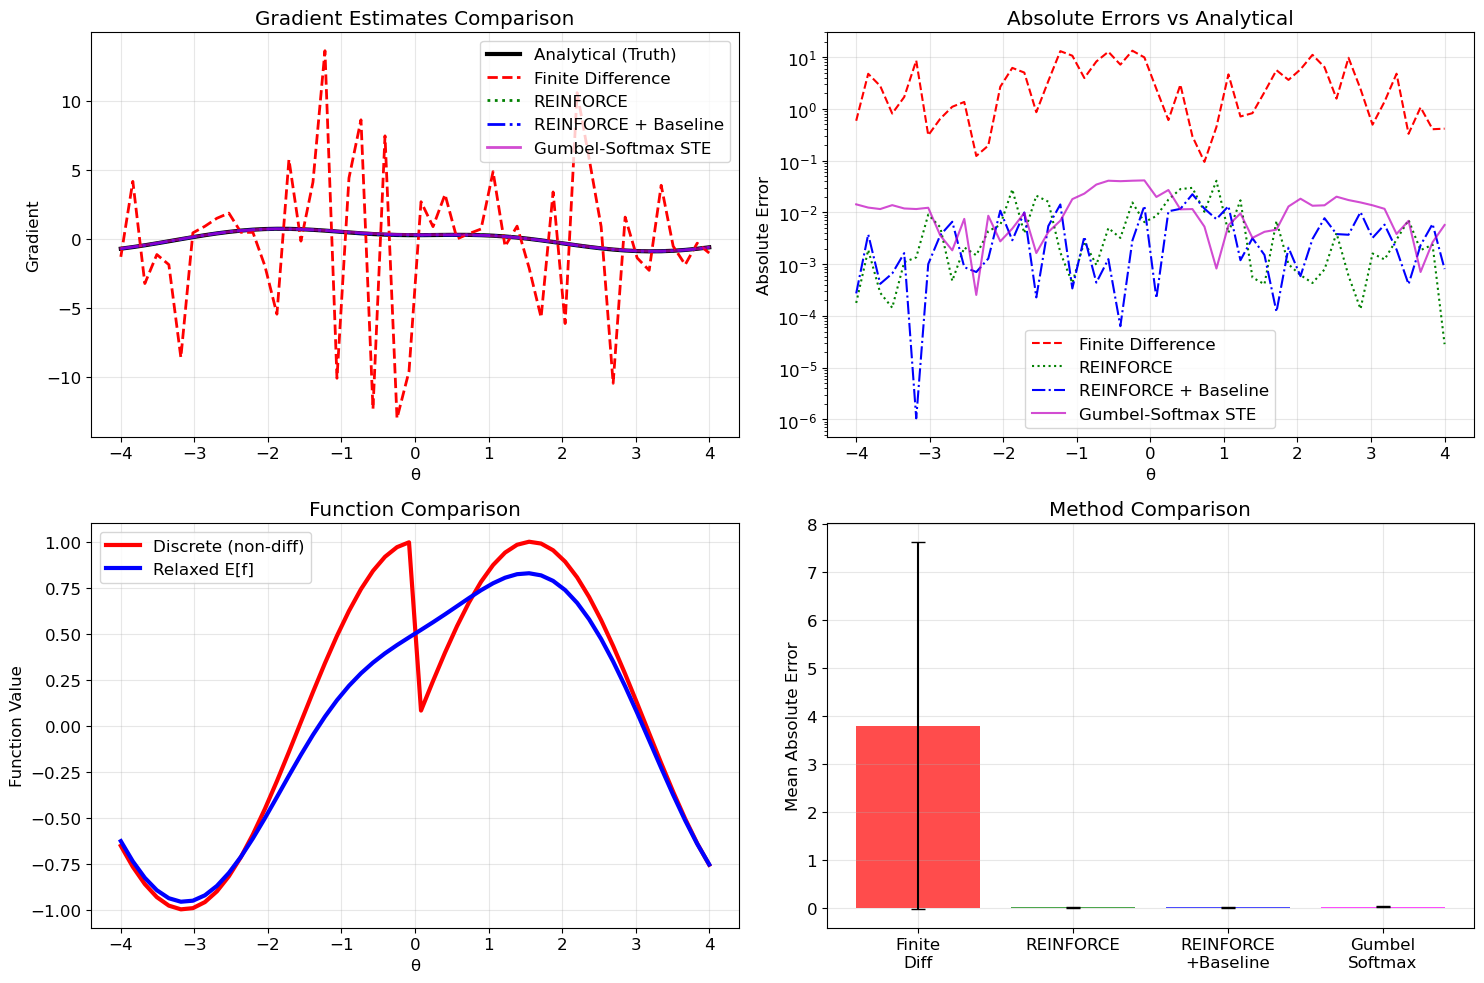


📊 SUMMARY STATISTICS:
Finite
Diff     | Mean Error: 3.799200 | Std: 3.835984
REINFORCE       | Mean Error: 0.006546 | Std: 0.009103
REINFORCE
+Baseline | Mean Error: 0.004421 | Std: 0.004873
Gumbel
Softmax  | Mean Error: 0.012785 | Std: 0.010825


In [23]:
# Compare all methods across parameter space
theta_range = np.linspace(-4, 4, 50)  # Reduced for computational efficiency
n_samples = 5000  # Reduced for speed

# Storage for results
analytical_grads = []
finite_diff_grads = []
reinforce_grads = []
reinforce_baseline_grads = []
gumbel_softmax_grads = []

print("🔄 Computing gradients across parameter space...")
print("This may take a moment...")

# Set seed for consistent comparison
np.random.seed(42)

for i, theta in enumerate(theta_range):
    if i % 10 == 0:
        print(f"Progress: {i/len(theta_range)*100:.0f}%")

    # Analytical (ground truth)
    analytical_grads.append(analytical_gradient(theta))

    # Finite difference
    finite_diff_grads.append(finite_difference_gradient(theta, n_samples))

    # REINFORCE variants
    reinforce_grads.append(reinforce_gradient(theta, n_samples))
    reinforce_baseline_grads.append(reinforce_gradient(theta, n_samples, f_relaxed(theta)))

    # Gumbel-Softmax
    gumbel_softmax_grads.append(gumbel_softmax_gradient(theta, n_samples))

print("✅ Computation complete!")

# Plot comparison
plt.figure(figsize=(15, 10))

# Gradient comparison
plt.subplot(2, 2, 1)
plt.plot(theta_range, analytical_grads, 'k-', linewidth=3, label='Analytical (Truth)')
plt.plot(theta_range, finite_diff_grads, 'r--', linewidth=2, label='Finite Difference')
plt.plot(theta_range, reinforce_grads, 'g:', linewidth=2, label='REINFORCE')
plt.plot(theta_range, reinforce_baseline_grads, 'b-.', linewidth=2, label='REINFORCE + Baseline')
plt.plot(theta_range, gumbel_softmax_grads, 'm-', linewidth=2, alpha=0.7, label='Gumbel-Softmax STE')
plt.xlabel('θ')
plt.ylabel('Gradient')
plt.title('Gradient Estimates Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Error analysis
plt.subplot(2, 2, 2)
finite_diff_errors = np.abs(np.array(finite_diff_grads) - np.array(analytical_grads))
reinforce_errors = np.abs(np.array(reinforce_grads) - np.array(analytical_grads))
reinforce_baseline_errors = np.abs(np.array(reinforce_baseline_grads) - np.array(analytical_grads))
gumbel_errors = np.abs(np.array(gumbel_softmax_grads) - np.array(analytical_grads))

plt.plot(theta_range, finite_diff_errors, 'r--', label='Finite Difference')
plt.plot(theta_range, reinforce_errors, 'g:', label='REINFORCE')
plt.plot(theta_range, reinforce_baseline_errors, 'b-.', label='REINFORCE + Baseline')
plt.plot(theta_range, gumbel_errors, 'm-', alpha=0.7, label='Gumbel-Softmax STE')
plt.xlabel('θ')
plt.ylabel('Absolute Error')
plt.title('Absolute Errors vs Analytical')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Function comparison
plt.subplot(2, 2, 3)
f_discrete_vals = [f_combined(t) for t in theta_range]
f_relaxed_vals = [f_relaxed(t) for t in theta_range]
plt.plot(theta_range, f_discrete_vals, 'r-', linewidth=3, label='Discrete (non-diff)')
plt.plot(theta_range, f_relaxed_vals, 'b-', linewidth=3, label='Relaxed E[f]')
plt.xlabel('θ')
plt.ylabel('Function Value')
plt.title('Function Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Statistics summary
plt.subplot(2, 2, 4)
methods = ['Finite\nDiff', 'REINFORCE', 'REINFORCE\n+Baseline', 'Gumbel\nSoftmax']
mean_errors = [
    np.mean(finite_diff_errors),
    np.mean(reinforce_errors),
    np.mean(reinforce_baseline_errors),
    np.mean(gumbel_errors)
]
std_errors = [
    np.std(finite_diff_errors),
    np.std(reinforce_errors),
    np.std(reinforce_baseline_errors),
    np.std(gumbel_errors)
]

x_pos = np.arange(len(methods))
plt.bar(x_pos, mean_errors, yerr=std_errors, capsize=5,
        color=['red', 'green', 'blue', 'magenta'], alpha=0.7)
plt.xticks(x_pos, methods)
plt.ylabel('Mean Absolute Error')
plt.title('Method Comparison')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print("=" * 50)
for method, errors in zip(methods, [finite_diff_errors, reinforce_errors,
                                   reinforce_baseline_errors, gumbel_errors]):
    print(f"{method:15} | Mean Error: {np.mean(errors):.6f} | Std: {np.std(errors):.6f}")

## 5. Interactive Exploration 🎮

Try experimenting with different parameters! Change the values below and see how they affect the estimates.

In [ ]:
# 🎛️ INTERACTIVE PARAMETER EXPLORATION
# Try changing these parameters and re-running the cell!

# Experiment parameters
THETA_EXPERIMENT = 1.0          # Try: -2, 0, 0.5, 2, etc.
N_SAMPLES_EXPERIMENT = 20000    # Try: 1000, 10000, 50000
N_RUNS = 100                    # Number of independent runs for variance analysis
TEMPERATURE = 0.5               # For Gumbel-Softmax (try: 0.1, 1.0, 2.0)

print(f"🧪 EXPERIMENT at θ = {THETA_EXPERIMENT}")
print(f"🎲 Using {N_SAMPLES_EXPERIMENT:,} samples over {N_RUNS} runs")
print("=" * 60)

# Run multiple independent experiments
analytical_truth = analytical_gradient(THETA_EXPERIMENT)
results = {
    'Finite Diff': [],
    'REINFORCE': [],
    'REINFORCE+Baseline': [],
    'Gumbel-Softmax': []
}

np.random.seed(None)  # Use different random seeds

for run in range(N_RUNS):
    # Set different seed for each run
    np.random.seed(run)

    results['Finite Diff'].append(
        finite_difference_gradient(THETA_EXPERIMENT, N_SAMPLES_EXPERIMENT)
    )
    results['REINFORCE'].append(
        reinforce_gradient(THETA_EXPERIMENT, N_SAMPLES_EXPERIMENT)
    )
    results['REINFORCE+Baseline'].append(
        reinforce_gradient(THETA_EXPERIMENT, N_SAMPLES_EXPERIMENT,
                          baseline=f_relaxed(THETA_EXPERIMENT))
    )
    results['Gumbel-Softmax'].append(
        gumbel_softmax_gradient(THETA_EXPERIMENT, N_SAMPLES_EXPERIMENT, TEMPERATURE)
    )

# Analyze results
print(f"Ground Truth (Analytical): {analytical_truth:.6f}")
print("-" * 60)
print("Method              | Mean      | Std       | Bias      | RMSE")
print("-" * 60)

for method, estimates in results.items():
    estimates = np.array(estimates)
    mean_est = np.mean(estimates)
    std_est = np.std(estimates)
    bias = mean_est - analytical_truth
    rmse = np.sqrt(np.mean((estimates - analytical_truth) ** 2))

    print(f"{method:18} | {mean_est:8.4f} | {std_est:8.4f} | {bias:8.4f} | {rmse:8.4f}")

# Visualize distributions
plt.figure(figsize=(15, 8))

# Box plots
plt.subplot(1, 2, 1)
data_to_plot = [results[method] for method in results.keys()]
box_plot = plt.boxplot(data_to_plot, labels=list(results.keys()), patch_artist=True)
colors = ['red', 'green', 'blue', 'magenta']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.axhline(analytical_truth, color='black', linestyle='-', linewidth=2,
           label=f'Analytical Truth = {analytical_truth:.4f}')
plt.ylabel('Gradient Estimate')
plt.title(f'Distribution of Estimates at θ = {THETA_EXPERIMENT}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Histogram for best method
plt.subplot(1, 2, 2)
best_method = min(results.keys(), key=lambda k: np.std(results[k]))
plt.hist(results[best_method], bins=20, alpha=0.7, color='blue',
         label=f'{best_method} (Lowest Variance)')
plt.axvline(analytical_truth, color='red', linestyle='--', linewidth=2,
           label=f'Truth = {analytical_truth:.4f}')
plt.axvline(np.mean(results[best_method]), color='green', linestyle='-', linewidth=2,
           label=f'Mean = {np.mean(results[best_method]):.4f}')
plt.xlabel('Gradient Estimate')
plt.ylabel('Frequency')
plt.title(f'Best Method Distribution: {best_method}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n🏆 Best method (lowest variance): {best_method}")
print(f"💡 Try different values of THETA_EXPERIMENT, N_SAMPLES_EXPERIMENT, and TEMPERATURE above!")

🧪 EXPERIMENT at θ = 1.0
🎲 Using 20,000 samples over 100 runs


## 6. Real-World Applications 🌍

The techniques you've learned here are fundamental to many cutting-edge machine learning applications:

### 🏗️ **Neural Architecture Search (NAS)**
- **Problem**: Choosing which operations to include in a neural network (conv, pool, skip, etc.)
- **Solution**: Use Gumbel-Softmax to make architectural choices differentiable
- **Impact**: Enables gradient-based architecture optimization instead of expensive search

### 🎯 **Reinforcement Learning**  
- **Problem**: Discrete action selection in policy gradient methods
- **Solution**: REINFORCE and its variants for policy optimization
- **Impact**: Foundation of modern RL algorithms like PPO, A3C

### 🎨 **Discrete Latent Variable Models**
- **Problem**: Learning with discrete latent variables (e.g., categorical VAEs)
- **Solution**: Gumbel-Softmax reparameterization trick
- **Impact**: Enables end-to-end training of discrete generative models

### 🔍 **Attention Mechanisms**
- **Problem**: Hard attention requires discrete selections
- **Solution**: Differentiable soft attention as relaxation
- **Impact**: Transformer architectures and modern NLP

### 🧬 **Combinatorial Optimization**
- **Problem**: Discrete optimization problems (TSP, graph problems)
- **Solution**: Continuous relaxations with these gradient estimators
- **Impact**: Neural approaches to classic optimization problems

Try implementing one of these applications next! 🚀

## 7. Key Takeaways and Summary 🎓

### 🧠 **Core Concepts Learned**

1. **The Problem**: Discrete decisions create non-differentiable functions
2. **The Solution**: Stochastic relaxation using probability distributions  
3. **The Trade-offs**: Different gradient estimators have different bias-variance characteristics

### ⚖️ **Method Comparison Summary**

| Method | Bias | Variance | Computational Cost | When to Use |
|--------|------|----------|-------------------|-------------|
| **Analytical** | ✅ None | ✅ None | ✅ Low | When derivable |
| **Finite Difference** | 🟨 Low | 🟨 Medium | 🟨 Medium | Simple baseline |
| **REINFORCE** | ✅ None | ❌ High | ✅ Low | Unbiased estimates needed |
| **REINFORCE + Baseline** | ✅ None | 🟨 Medium | ✅ Low | Better REINFORCE |
| **Gumbel-Softmax STE** | ❌ Biased | ✅ Low | 🟨 Medium | Low variance needed |

### 🎯 **When to Use Each Method**

- **Start with analytical** if possible (zero bias, zero variance)
- **Use REINFORCE + baseline** for unbiased estimates with manageable variance
- **Use Gumbel-Softmax** when you can tolerate bias for lower variance
- **Use finite difference** as a simple baseline for validation

### 💡 **Key Insights**

1. **Stochastic relaxation** transforms hard discrete problems into soft continuous ones
2. **Expectation** preserves the essential behavior while enabling gradients
3. **Baseline techniques** can dramatically reduce variance in policy gradient methods
4. **Temperature parameters** in Gumbel-Softmax control the bias-variance trade-off

### 🚀 **Next Steps**

- Try applying these techniques to your own discrete decision problems
- Experiment with different baseline functions for REINFORCE
- Explore more sophisticated relaxation techniques (e.g., concrete distributions)
- Implement these methods in modern deep learning frameworks (PyTorch, JAX)

**Congratulations! You now understand the fundamentals of differentiable discrete decisions!** 🎉

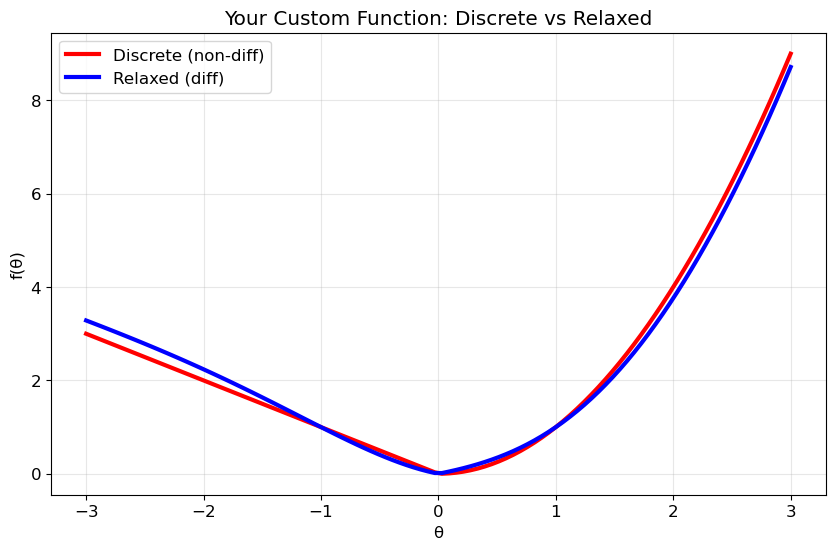

🎉 Great job! You've implemented your own differentiable discrete decision!
💡 Now try applying the gradient estimation techniques to your function!

📚 REFERENCES AND FURTHER READING:
🔗 Original Papers:
   • REINFORCE: Williams (1992) - Simple Statistical Gradient-Following
   • Gumbel-Softmax: Jang et al. (2017) - Categorical Reparameterization
   • Concrete Distribution: Maddison et al. (2017)

🔗 Applications:
   • Neural Architecture Search: Liu et al. (2019) - DARTS
   • Discrete VAEs: Rolfe (2017)
   • Hard Attention: Xu et al. (2015)

🔗 Modern Implementations:
   • PyTorch: torch.distributions.RelaxedBernoulli
   • JAX: jax.nn.gumbel_softmax
   • TensorFlow: tfp.distributions.RelaxedBernoulli

🎓 Thank you for completing this tutorial!
Happy differentiating! 🚀


In [ ]:
# 🎯 FINAL EXERCISE: Try Your Own Function!
#
# Modify the function below to create your own discrete decision problem
# and apply the techniques you've learned!

def my_custom_function(theta, k):
    """
    EXERCISE: Create your own piecewise function!

    Ideas:
    - f(θ,k) = θ² if k=1, else θ³
    - f(θ,k) = exp(θ) if k=1, else log(1+θ²)
    - f(θ,k) = max(θ,0) if k=1, else min(θ,0)
    """
    # TODO: Replace this with your own function!
    if k == 1:
        return theta**2  # Quadratic branch
    else:
        return np.abs(theta)  # Absolute value branch

def my_custom_relaxed(theta):
    """The relaxed version of your custom function"""
    p = sigmoid(theta)
    return p * (theta**2) + (1 - p) * np.abs(theta)

# Test your custom function
theta_test_custom = np.linspace(-3, 3, 100)
discrete_vals = [my_custom_function(t, 1 if t >= 0 else 0) for t in theta_test_custom]
relaxed_vals = [my_custom_relaxed(t) for t in theta_test_custom]

plt.figure(figsize=(10, 6))
plt.plot(theta_test_custom, discrete_vals, 'r-', linewidth=3, label='Discrete (non-diff)')
plt.plot(theta_test_custom, relaxed_vals, 'b-', linewidth=3, label='Relaxed (diff)')
plt.xlabel('θ')
plt.ylabel('f(θ)')
plt.title('Your Custom Function: Discrete vs Relaxed')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("🎉 Great job! You've implemented your own differentiable discrete decision!")
print("💡 Now try applying the gradient estimation techniques to your function!")

# ============================================================================
# 📚 REFERENCES AND FURTHER READING
# ============================================================================

print("\n📚 REFERENCES AND FURTHER READING:")
print("=" * 50)
print("🔗 Original Papers:")
print("   • REINFORCE: Williams (1992) - Simple Statistical Gradient-Following")
print("   • Gumbel-Softmax: Jang et al. (2017) - Categorical Reparameterization")
print("   • Concrete Distribution: Maddison et al. (2017)")
print("\n🔗 Applications:")
print("   • Neural Architecture Search: Liu et al. (2019) - DARTS")
print("   • Discrete VAEs: Rolfe (2017)")
print("   • Hard Attention: Xu et al. (2015)")
print("\n🔗 Modern Implementations:")
print("   • PyTorch: torch.distributions.RelaxedBernoulli")
print("   • JAX: jax.nn.gumbel_softmax")
print("   • TensorFlow: tfp.distributions.RelaxedBernoulli")

print("\n🎓 Thank you for completing this tutorial!")
print("Happy differentiating! 🚀")